Training shape: (4435, 37)
Testing shape: (2000, 37)

Training TabDDPM...
Epoch 1, Loss: 0.7926
Epoch 2, Loss: 0.3590
Epoch 3, Loss: 0.2392
Epoch 4, Loss: 0.2303
Epoch 5, Loss: 0.2164
Epoch 6, Loss: 0.2065
Epoch 7, Loss: 0.2035
Epoch 8, Loss: 0.2030
Epoch 9, Loss: 0.2012
Epoch 10, Loss: 0.2020

Evaluating model on test set...

Denoising Evaluation Metrics:
- MSE: 0.1998
- R² Score: 0.7980

Generating synthetic samples...
Synthetic data saved to synthetic_data.csv

Plotting heatmaps...


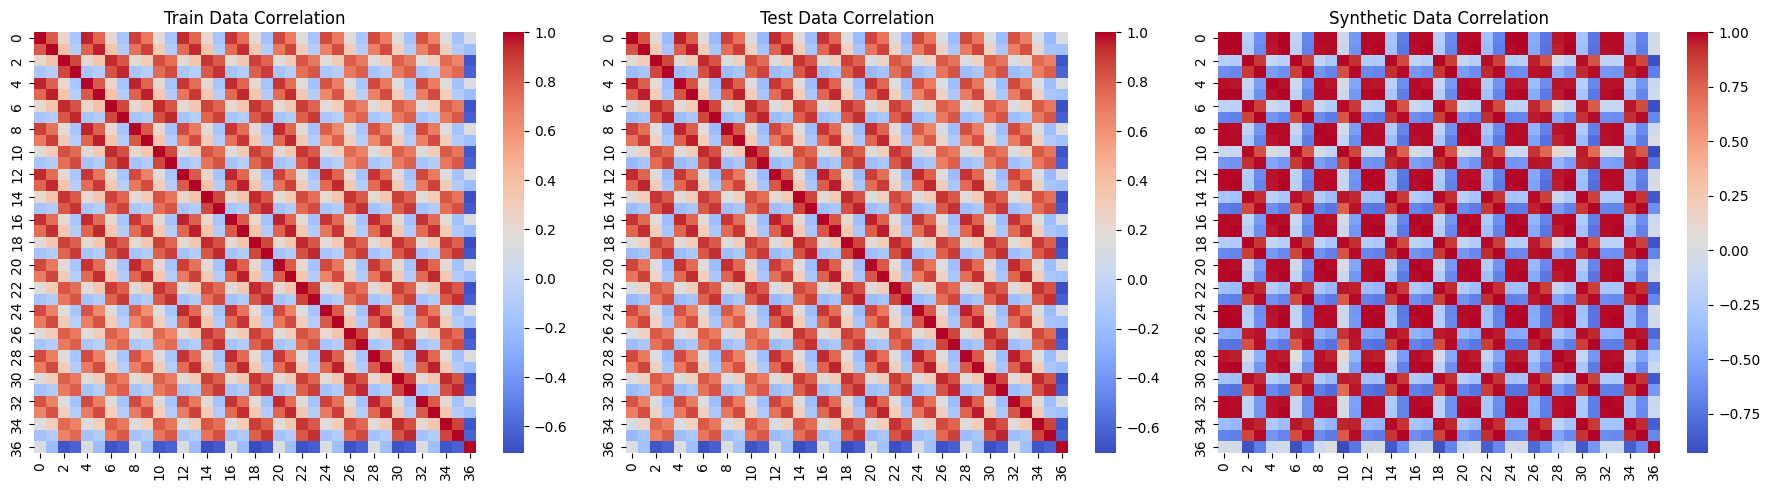

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

# MLP for denoising network
def get_mlp(in_dim, out_dim):
    return nn.Sequential(
        nn.Linear(in_dim + 1, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, out_dim),
    )

class TabDDPM(nn.Module):
    def __init__(self, input_dim, timesteps=1000):
        super(TabDDPM, self).__init__()
        self.input_dim = input_dim
        self.timesteps = timesteps
        self.model = get_mlp(input_dim, input_dim)

        betas = torch.linspace(1e-4, 0.02, timesteps)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', 1. - betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(1. - betas, dim=0))

    def forward(self, x, t):
        t_embed = t.float().unsqueeze(1) / self.timesteps
        x_in = torch.cat([x, t_embed], dim=1)
        return self.model(x_in)

    def q_sample(self, x0, t):
        noise = torch.randn_like(x0)
        sqrt_alpha_cumprod = self.alphas_cumprod[t].sqrt().unsqueeze(1)
        sqrt_one_minus_alpha_cumprod = (1 - self.alphas_cumprod[t]).sqrt().unsqueeze(1)
        return sqrt_alpha_cumprod * x0 + sqrt_one_minus_alpha_cumprod * noise, noise

    def sample(self, num_samples):
        x = torch.randn(num_samples, self.input_dim)
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((num_samples,), t, dtype=torch.long)
            pred_noise = self.forward(x, t_tensor)
            beta = self.betas[t]
            alpha = self.alphas[t]
            alpha_hat = self.alphas_cumprod[t]
            coef = 1 / alpha.sqrt()
            noise = torch.randn_like(x) if t > 0 else 0
            x = coef * (x - beta / (1 - alpha_hat).sqrt() * pred_noise) + beta.sqrt() * noise
        return x

# Load and preprocess your data
train_path = "/content/sat_train.csv"
test_path = "/content/sat_test.csv"

# Load CSVs
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Select numeric columns only
train_df = train_df.select_dtypes(include=[np.number]).dropna()
test_df = test_df.select_dtypes(include=[np.number]).dropna()

print(f"Training shape: {train_df.shape}")
print(f"Testing shape: {test_df.shape}")

# Normalize data
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(train_df.values), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(test_df.values), dtype=torch.float32)

# Dataloader
train_loader = DataLoader(TensorDataset(X_train), batch_size=64, shuffle=True)

# Initialize model
input_dim = X_train.shape[1]
model = TabDDPM(input_dim=input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# === TRAINING LOOP ===
print("\nTraining TabDDPM...")
model.train()
for epoch in range(10):
    total_loss = 0
    for batch in train_loader:
        x0 = batch[0]
        t = torch.randint(0, model.timesteps, (x0.size(0),), dtype=torch.long)
        xt, noise = model.q_sample(x0, t)
        pred_noise = model(xt, t)
        loss = loss_fn(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# === EVALUATION ===
print("\nEvaluating model on test set...")
model.eval()
with torch.no_grad():
    t_test = torch.randint(0, model.timesteps, (X_test.size(0),), dtype=torch.long)
    xt, true_noise = model.q_sample(X_test, t_test)
    pred_noise = model(xt, t_test)

    mse = mean_squared_error(true_noise.numpy(), pred_noise.numpy())
    r2 = r2_score(true_noise.numpy(), pred_noise.numpy())
    print(f"\nDenoising Evaluation Metrics:\n- MSE: {mse:.4f}\n- R² Score: {r2:.4f}")

# === GENERATE SYNTHETIC DATA ===
print("\nGenerating synthetic samples...")
with torch.no_grad():
    samples = model.sample(100).numpy()
    samples_rescaled = scaler.inverse_transform(samples)
    df_synth = pd.DataFrame(samples_rescaled, columns=train_df.columns)
    df_synth.to_csv("synthetic_data.csv", index=False)
    print("Synthetic data saved to synthetic_data.csv")

# === HEATMAPS ===
print("\nPlotting heatmaps...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(train_df.corr(), ax=axes[0], cmap="coolwarm", annot=False)
axes[0].set_title("Train Data Correlation")

sns.heatmap(test_df.corr(), ax=axes[1], cmap="coolwarm", annot=False)
axes[1].set_title("Test Data Correlation")

sns.heatmap(df_synth.corr(), ax=axes[2], cmap="coolwarm", annot=False)
axes[2].set_title("Synthetic Data Correlation")

plt.tight_layout()
plt.show()
